# Predicting yearly availability of different hotels.

## Importing libraries

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
import xgboost
import lightgbm

C:\Users\tamar\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

## Data Wrangling & Visualization

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1


In [4]:
#Explore columns
data.columns

Index(['id', 'region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id',
       'owned_hotels', 'yearly_availability'],
      dtype='object')

In [5]:
# Explore whether the data is balanced or not
data.groupby(['yearly_availability'])['yearly_availability'].count()

yearly_availability
0    1439
1    1431
Name: yearly_availability, dtype: int64

In [6]:
# Description
data.describe()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
count,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2194.000000,2.870000e+03,2870.000000,2870.000000
mean,26760.657143,40.731224,-73.950158,195.943206,11.530314,16.315331,1.157502,7.202195e+07,8.411498,0.498606
std,14140.930062,0.054942,0.049745,406.184714,37.972339,32.481722,1.355028,8.076516e+07,27.105522,0.500085
min,0.000000,40.507080,-74.242850,10.000000,1.000000,0.000000,0.010000,2.787000e+03,1.000000,0.000000
25%,15931.750000,40.692463,-73.984003,75.000000,1.000000,1.000000,0.240000,7.388002e+06,1.000000,0.000000
50%,28946.500000,40.728250,-73.956720,120.000000,3.000000,4.000000,0.650000,3.352708e+07,1.000000,0.000000
75%,38478.500000,40.762658,-73.934202,200.000000,6.000000,16.000000,1.530000,1.207625e+08,3.000000,1.000000
max,48893.000000,40.898730,-73.721730,9999.000000,999.000000,395.000000,10.370000,2.738123e+08,327.000000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2870 non-null   int64  
 1   region               2870 non-null   object 
 2   latitude             2870 non-null   float64
 3   longitude            2870 non-null   float64
 4   accommodation_type   2870 non-null   object 
 5   cost                 2870 non-null   int64  
 6   minimum_nights       2870 non-null   int64  
 7   number_of_reviews    2870 non-null   int64  
 8   reviews_per_month    2194 non-null   float64
 9   owner_id             2870 non-null   int64  
 10  owned_hotels         2870 non-null   int64  
 11  yearly_availability  2870 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 269.2+ KB


#### Droping N/A rows

In [8]:
data.dropna(inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 0 to 2869
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2194 non-null   int64  
 1   region               2194 non-null   object 
 2   latitude             2194 non-null   float64
 3   longitude            2194 non-null   float64
 4   accommodation_type   2194 non-null   object 
 5   cost                 2194 non-null   int64  
 6   minimum_nights       2194 non-null   int64  
 7   number_of_reviews    2194 non-null   int64  
 8   reviews_per_month    2194 non-null   float64
 9   owner_id             2194 non-null   int64  
 10  owned_hotels         2194 non-null   int64  
 11  yearly_availability  2194 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 222.8+ KB


#### Converting categorical columns to 1 or 0 valued columns to use them in prediction

In [10]:
category_cols = ['region', 'accommodation_type']
data = pd.get_dummies(data, columns=category_cols, drop_first=True)
data.head()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island,accommodation_type_Private room,accommodation_type_Shared room
0,13232,40.71854,-74.00439,170,5,7,0.56,929983,1,0,0,1,0,0,0,0
1,246,40.64446,-73.95030,65,3,238,2.30,281764,1,0,1,0,0,0,0,0
4,444,40.82426,-73.94630,75,3,38,0.42,745069,3,1,0,1,0,0,0,1
5,30553,40.73976,-74.00953,200,10,11,0.76,11243113,1,1,0,1,0,0,1,0
6,30500,40.67913,-73.98015,95,1,8,0.52,1746811,2,0,1,0,0,0,0,0


## Feature selection

In [11]:
data.columns

Index(['id', 'latitude', 'longitude', 'cost', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'owner_id', 'owned_hotels',
       'yearly_availability', 'region_Brooklyn', 'region_Manhattan',
       'region_Queens', 'region_Staten Island',
       'accommodation_type_Private room', 'accommodation_type_Shared room'],
      dtype='object')

In [12]:
features_data = data[['latitude', 'longitude', 'cost', 'minimum_nights', 'number_of_reviews',
                      'reviews_per_month', 'owner_id', 'owned_hotels', 'region_Brooklyn', 
                      'region_Manhattan', 'region_Queens', 'region_Staten Island', 
                      'accommodation_type_Private room', 'accommodation_type_Shared room']]
target_data = data[['yearly_availability']]
X_features = features_data.values
Y = target_data.values

In [13]:
# Create an SelectKBest object to select features with two best ANOVA F-Statistics
fvalue_selector_features = SelectKBest(f_classif, k=5)
# Apply the SelectKBest object to the features and target
X_kbest_features = fvalue_selector_features.fit_transform(X_features, Y)
f_statistics = fvalue_selector_features.scores_
p_values = fvalue_selector_features.pvalues_
selected_feature_cloumns = fvalue_selector_features.get_support(indices = True)

C:\Users\tamar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
anova_results = pd.DataFrame()
anova_results['features'] = features_data.columns
anova_results['f_statistics'] = f_statistics
anova_results['f_statistics'] = np.round(anova_results['f_statistics'], 2)
anova_results['p_value'] = p_values
anova_results['p_value'] = anova_results['p_value']
anova_results = anova_results.sort_values(by=['f_statistics'], ascending=False)
anova_results

,features,f_statistics,p_value
12,accommodation_type_Private room,1335.06,1.095262e-228
5,reviews_per_month,146.97,8.702806e-33
7,owned_hotels,126.66,1.318049e-28
1,longitude,62.34,4.538060e-15
2,cost,46.13,1.422091e-11
3,minimum_nights,45.34,2.108288e-11
4,number_of_reviews,39.16,4.682556e-10
10,region_Queens,31.95,1.792332e-08
13,accommodation_type_Shared room,19.05,1.332559e-05
6,owner_id,14.18,1.708381e-04


In [15]:
# Droping features with less than 3% p-value
data.drop(labels = ['region_Brooklyn', 'latitude', 'region_Staten Island'], axis=1, inplace=True)

<Axes: >

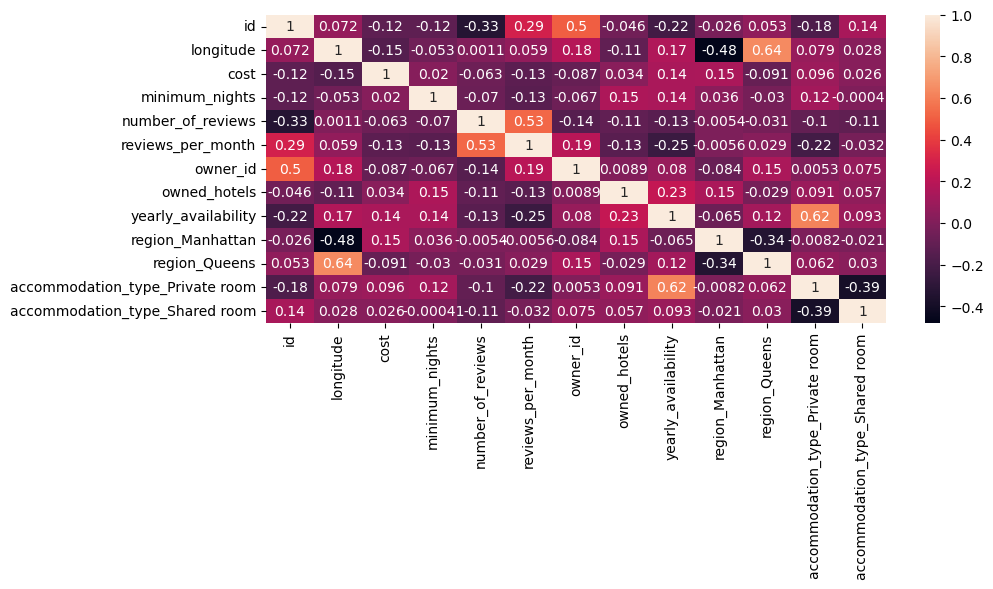

In [16]:
# Checking features correlation
plt.figure(figsize=(10,4))
sns.heatmap(data.corr(), annot = True)

In [17]:
# Droping the features with more than 0.6 correlation
data.drop(labels = ['longitude'], axis=1, inplace=True)

## Training

In [18]:
X = data.drop(['id', 'yearly_availability'], axis=1)
y = data['yearly_availability']

In [19]:
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 42)

In [20]:
# Feature normaization
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [21]:
models = {'Logistic_Regression': LogisticRegression(class_weight='balanced'),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'Random_Forest': RandomForestClassifier(max_depth=None, max_features='sqrt',
                         min_samples_leaf=3,
                         min_samples_split=17,
                         n_estimators=20),
         'XGBoost': xgboost.XGBClassifier(objective = 'binary:logistic', 
                            scale_pos_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train), 
                                          use_label_encoder = False, nthread = -1, eval_metric = 'logloss', 
                                          random_state = 42, subsample=0.6, n_estimators=500, min_child_weight=1,
                                          max_depth=3, learning_rate=0.1, gamma=5, colsample_bytree=0.8),
         'CATBoost': CatBoostClassifier(iterations=5, learning_rate=0.1),
          'LightGBM': lightgbm.LGBMClassifier(num_leaves=1550, max_depth=3, n_estimators=50, learning_rate=0.1)
                                        }

for model_name, model in models.items():
    model.fit(X_train_normalized, y_train)
    predict = model.predict(X_test_normalized)    
    score = cross_val_score(model.fit(X_train_normalized,y_train), X, y, cv = 5)
    #print(model_name, f1_score(y_test, predict))
    print(model_name)
    print(classification_report(y_test, predict))
    print("====================\n")
    print(score.mean())

Logistic_Regression
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       192
           1       0.78      0.92      0.84       138

    accuracy                           0.86       330
   macro avg       0.86      0.87      0.86       330
weighted avg       0.87      0.86      0.86       330


0.4170468374574844
KNN
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       192
           1       0.86      0.86      0.86       138

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330


0.5897827149707201


C:\Users\tamar\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\tamar\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Random_Forest
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       192
           1       0.90      0.93      0.91       138

    accuracy                           0.93       330
   macro avg       0.92      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330


0.9184135800542952


C:\Users\tamar\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\tamar\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\tamar\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\tamar\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

XGBoost
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       192
           1       0.89      0.93      0.91       138

    accuracy                           0.92       330
   macro avg       0.92      0.93      0.92       330
weighted avg       0.93      0.92      0.92       330


0.9234280899928231
0:	learn: 0.6352801	total: 182ms	remaining: 729ms
1:	learn: 0.5851792	total: 190ms	remaining: 285ms
2:	learn: 0.5439847	total: 196ms	remaining: 131ms
3:	learn: 0.5069995	total: 203ms	remaining: 50.9ms
4:	learn: 0.4753905	total: 210ms	remaining: 0us
0:	learn: 0.6352801	total: 3.55ms	remaining: 14.2ms
1:	learn: 0.5851792	total: 7.94ms	remaining: 11.9ms
2:	learn: 0.5439847	total: 10.5ms	remaining: 7.02ms
3:	learn: 0.5069995	total: 12ms	remaining: 3ms
4:	learn: 0.4753905	total: 13.3ms	remaining: 0us
0:	learn: 0.6346614	total: 1.89ms	remaining: 7.57ms
1:	learn: 0.5832797	total: 3.95ms	remaining: 5.92ms
2:	learn: 0.5411317	total: 5.33ms	remain

#### As we can see the best performing model is XGBoost, because it has the highest accuracy. Now we will perform Randomized Search to find best parameters for XGBoost model.

### Randomized Search XGBoost

In [22]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10],
        'n_estimators': [100, 500, 1000],
        'learning_rate':[0.1, 0.15, 0.2]
        }

xgb = xgboost.XGBClassifier(objective = 'binary:logistic', 
                            scale_pos_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train), 
                            use_label_encoder = False, nthread = -1, eval_metric = 'logloss', random_state = 42)

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions = params, scoring = 'f1_macro', n_jobs = -1, 
                                   cv = skf.split(X_train, y_train), verbose = 3, random_state = 42)

random_search.fit(X_train_normalized, y_train)

print('Best Score:')
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score:
0.9237382875359078

 Best hyperparameters:
{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [23]:
# Training the model with best hyperparameters
model = xgboost.XGBClassifier(objective = 'binary:logistic',
                              scale_pos_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train), 
                              use_label_encoder = False, nthread = -1, 
                              eval_metric = 'logloss',
                              random_state = 42,
                              subsample=1.0,
                              n_estimators=100,
                              min_child_weight=5,
                              max_depth=5,
                              learning_rate=0.1,
                              gamma=0.5,
                              colsample_bytree=0.8)
model.fit(X_train_normalized, y_train)
predict = model.predict(X_test_normalized)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       192
           1       0.90      0.93      0.91       138

    accuracy                           0.93       330
   macro avg       0.92      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



## Task:
**Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `yearly_availability` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **yearly_availability**

In [24]:
data_test = pd.read_csv("test.csv")

In [25]:
submission_df = pd.DataFrame(columns=['id', 'yearly_availability'])
submission_df['id'] = data_test['id']

In [26]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  718 non-null    int64  
 1   region              718 non-null    object 
 2   latitude            718 non-null    float64
 3   longitude           718 non-null    float64
 4   accommodation_type  718 non-null    object 
 5   cost                718 non-null    int64  
 6   minimum_nights      718 non-null    int64  
 7   number_of_reviews   718 non-null    int64  
 8   reviews_per_month   545 non-null    float64
 9   owner_id            718 non-null    int64  
 10  owned_hotels        718 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 61.8+ KB


In [27]:
data_test.reviews_per_month.fillna(0, inplace=True)

In [28]:
data_test.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,0.00,13773574,12
3,33694,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,28873,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2


In [29]:
category_cols = ['region', 'accommodation_type']
data_test = pd.get_dummies(data_test, columns=category_cols, drop_first=True)

In [30]:
data_test.drop(labels = ['id', 'region_Brooklyn', 'latitude', 'region_Staten Island', 'longitude'], axis=1, inplace=True)

In [31]:
data_test_normalized = scaler.transform(data_test)

In [32]:
predict_test = model.predict(data_test_normalized) 

In [33]:
submission_df['yearly_availability'] = predict_test

In [34]:
submission_df

,id,yearly_availability
0,19215,0
1,36301,0
2,40566,1
3,33694,0
4,28873,0
...,...,...
713,26801,0
714,20110,0
715,31383,0
716,47135,1


In [35]:
submission_df.to_csv('submissions.csv',index=False)